# Эксперимент №2
https://archive.ics.uci.edu/ml/datasets/Parkinsons+Telemonitoring

In [1]:
import sys
import os

sys.path.append('..')
folder_path = os.path.abspath(os.path.join(os.getcwd(), "../../evaluate"))
sys.path.append(folder_path)

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tools import deletion_features
from tools import balancing
from tools import encoder
from tools import scaling
from Alg_CatBoost import CatBoostRegressor_fill 
from Alg_DecisionTree import DecisionTreeRegressor_fill
from Alg_Interpolate import interpolate_fill
from Alg_KNNImputer import KNNImputer_fill
from Alg_LinearRegression import LinearRegression_fill
from Alg_max import max_fill
from Alg_mean import mean_fill 
from Alg_median import median_fill
from Alg_min import min_fill
from Alg_RandomForestRegressor import RandomForestRegressor_fill
from Alg_SVR import SVR_fill
from Alg_XGBRegressor import XGBRegressor_fill
import results_metrics
import results_metrics_visualization

In [3]:
#считываем тренировочные данные
df = pd.read_csv('./Data/parkinsons_updrs.csv')

df.shape

(5875, 22)

# 1. Исследуем данные

In [4]:
df.head()

subject#  age  sex  test_time  motor_UPDRS  total_UPDRS  Jitter(%)  \
0         1   72    0     5.6431       28.199       34.398    0.00662   
1         1   72    0    12.6660       28.447       34.894    0.00300   
2         1   72    0    19.6810       28.695       35.389    0.00481   
3         1   72    0    25.6470       28.905       35.810    0.00528   
4         1   72    0    33.6420       29.187       36.375    0.00335   

   Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  ...  Shimmer(dB)  Shimmer:APQ3  \
0     0.000034     0.00401      0.00317  ...        0.230       0.01438   
1     0.000017     0.00132      0.00150  ...        0.179       0.00994   
2     0.000025     0.00205      0.00208  ...        0.181       0.00734   
3     0.000027     0.00191      0.00264  ...        0.327       0.01106   
4     0.000020     0.00093      0.00130  ...        0.176       0.00679   

   Shimmer:APQ5  Shimmer:APQ11  Shimmer:DDA       NHR     HNR     RPDE  \
0       0.01309        0.01662      0.04314  0.014290  21.640  0.41888   
1       0.01072        0.01689      0.02982  0.011112  27.183  0.43493   
2       0.00844        0.01458      0.02202  0.020220  23.047  0.46222   
3       0.01265        0.01963      0.03317  0.027837  24.445  0.48730   
4       0.00929        0.01819      0.02036  0.011625  26.126  0.47188   

       DFA      PPE  
0  0.54842  0.16006  
1  0.56477  0.10810  
2  0.54405  0.21014  
3  0.57794  0.33277  
4  0.56122  0.19361  

[5 rows x 22 columns]

In [5]:
#проверим данные на типы
df.dtypes

subject#           int64
age                int64
sex                int64
test_time        float64
motor_UPDRS      float64
total_UPDRS      float64
Jitter(%)        float64
Jitter(Abs)      float64
Jitter:RAP       float64
Jitter:PPQ5      float64
Jitter:DDP       float64
Shimmer          float64
Shimmer(dB)      float64
Shimmer:APQ3     float64
Shimmer:APQ5     float64
Shimmer:APQ11    float64
Shimmer:DDA      float64
NHR              float64
HNR              float64
RPDE             float64
DFA              float64
PPE              float64
dtype: object

In [6]:
#проверим на пропуски
df.isna().sum()

subject#         0
age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter(%)        0
Jitter(Abs)      0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer(dB)      0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64

In [7]:
df.columns

Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')

In [8]:
print(len(df.columns))

22


<AxesSubplot:>

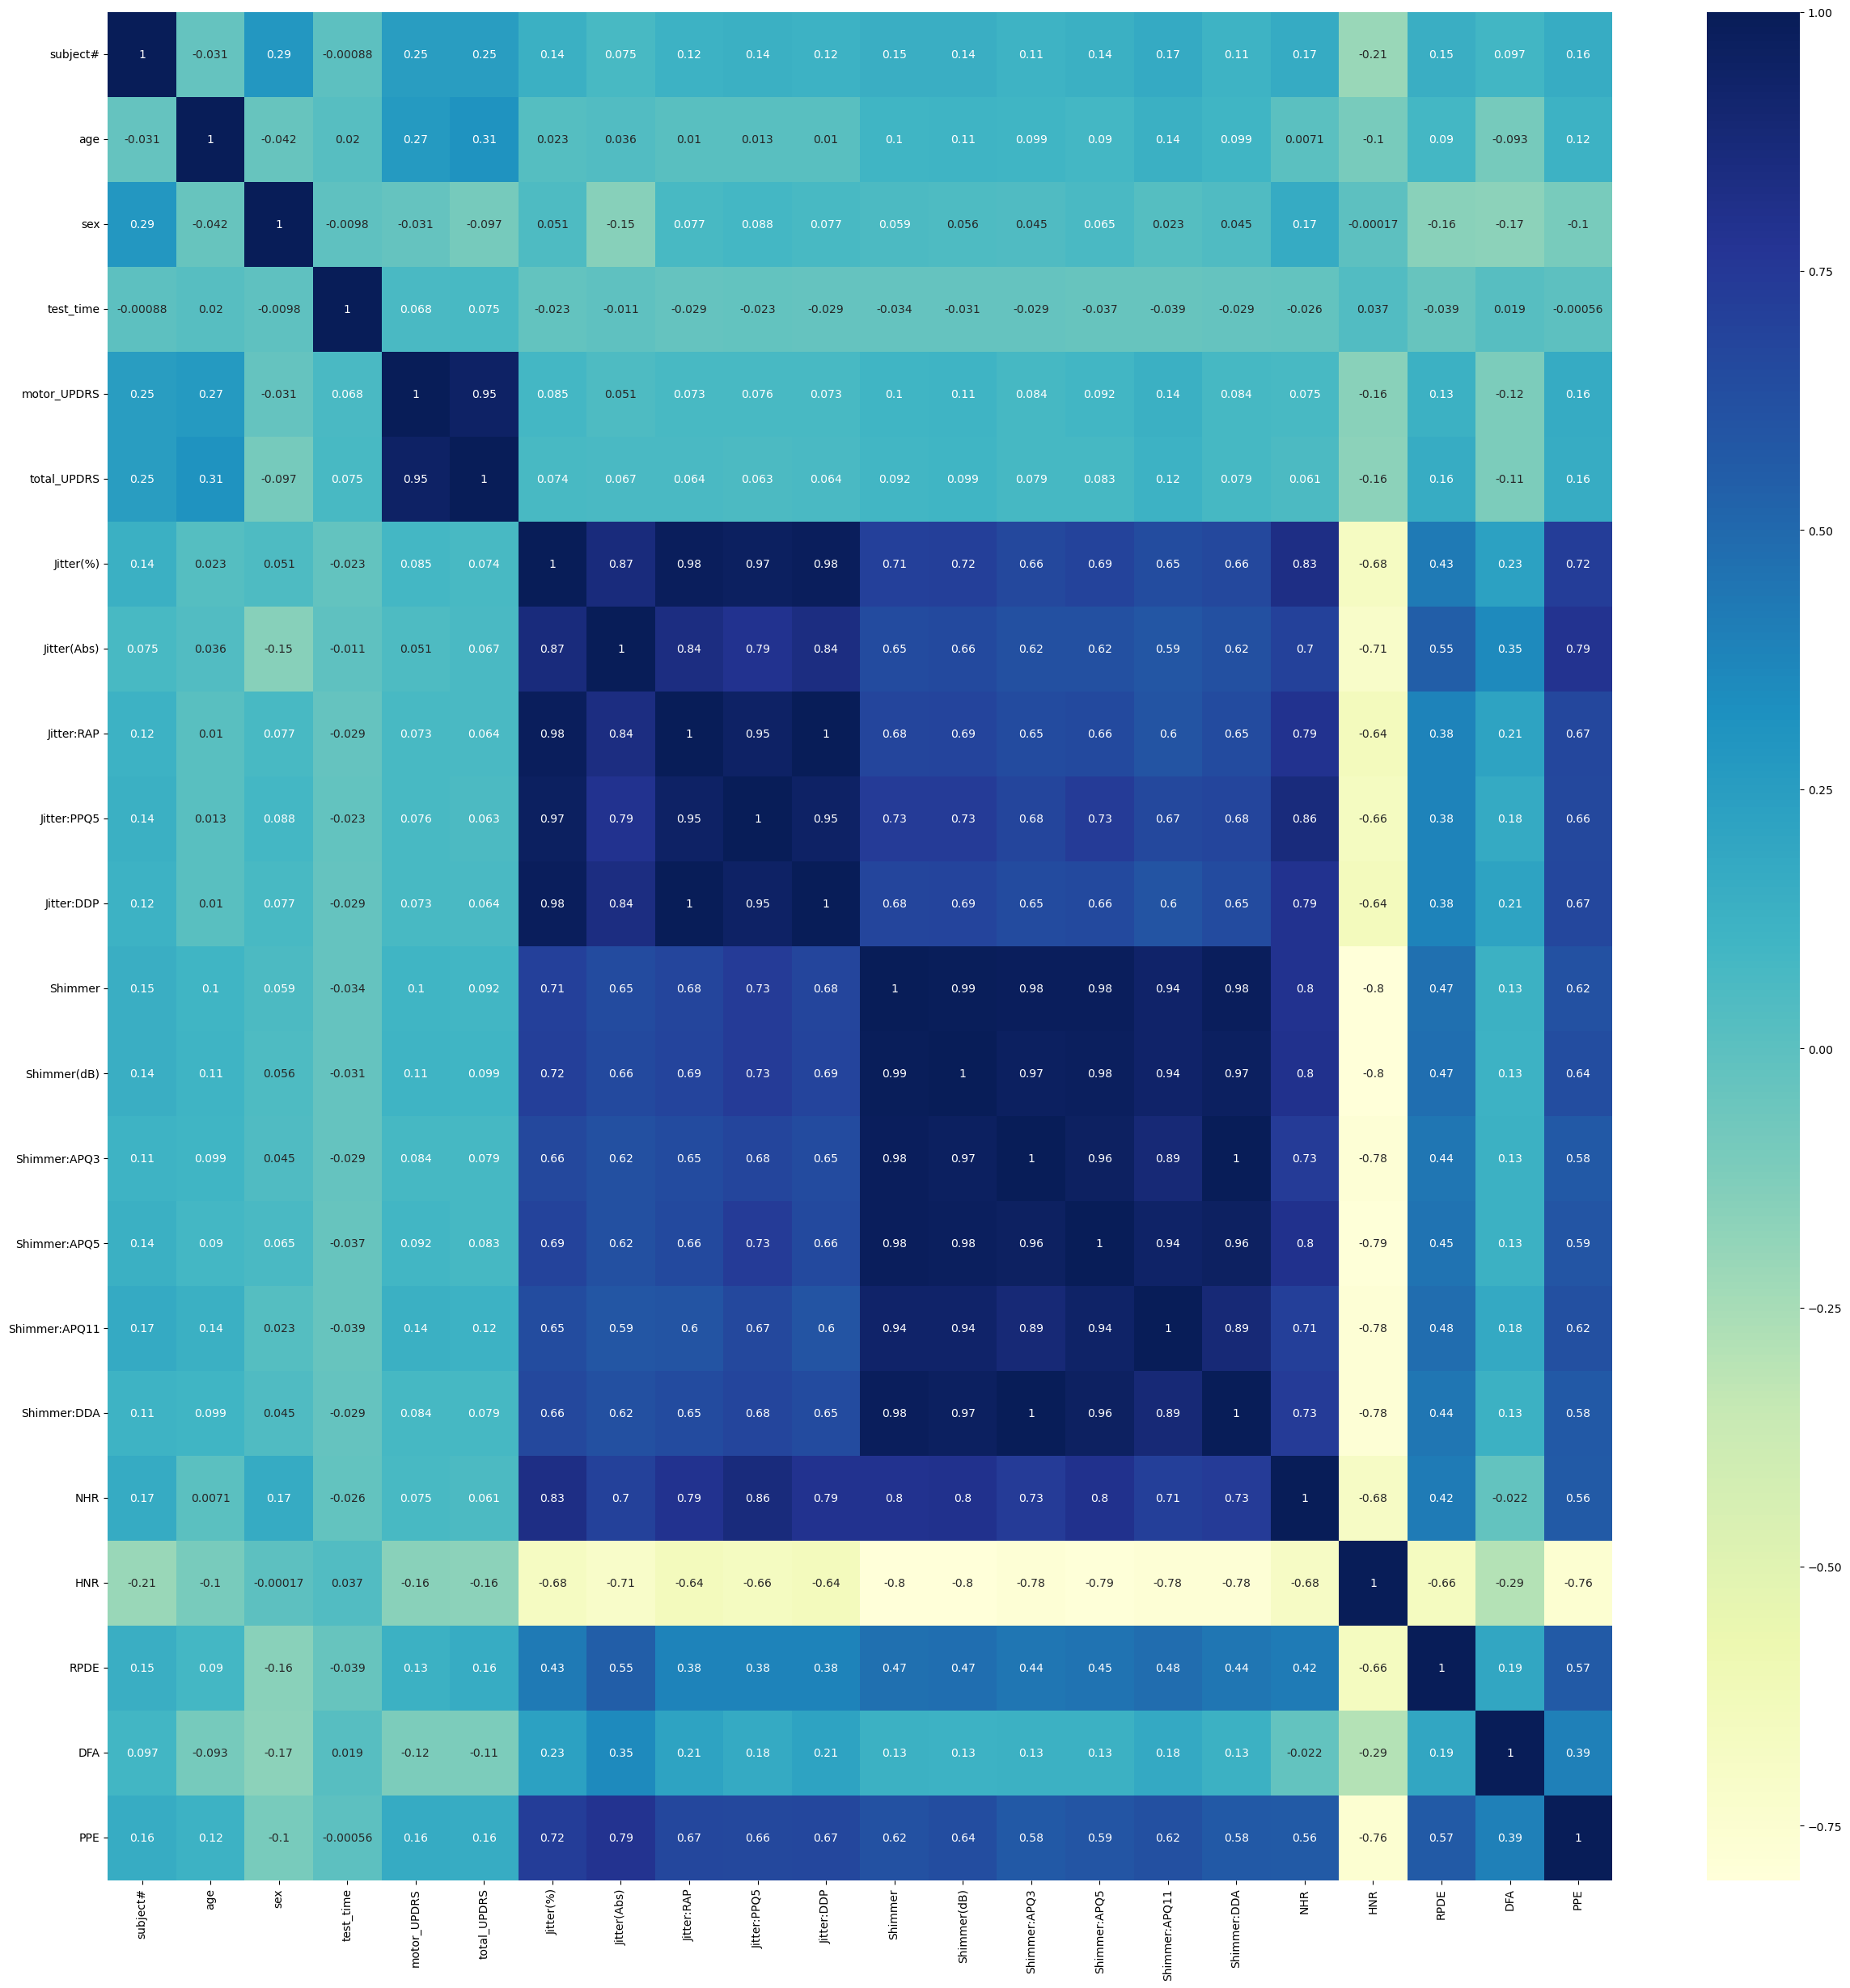

In [9]:
#построим корреляционную матрицу
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(),cmap='YlGnBu', annot=True)

# 2. Произведем предобработку данных

# 2.1. Балансировка данных

Задача состоит в предсказании ответов для признаков "motor_UPDRS" и "total_UPDRS" -  двигательные и общие баллы UPDRS. Эти данные предсказываются на основе биомедицинских показателй каждого пациента. Нам не нужно балансировать данные признаки, так как они являются количественными. Далее будет проведена работа с аномалиями и произведено масштабирование данных.

# 2.2. Кодирование данных

В данных отсутсвуют признаки, содержащие категориальные значения, как следствие кодирование признаков не треуется

# 2.3. Устранение дубликатов

In [10]:
df.shape

(5875, 22)

In [11]:
#проверяем наличие дубликатов и удаляем их
data = df.drop_duplicates()

In [12]:
data.shape

(5875, 22)

# 2.4. Работа с аномалиями

Проверяем на аномалии и устраняем их

Информация об атрибутах:
- subject — Целое число, однозначно идентифицирующее
- age каждого испытуемого — Возраст испытуемого
- sex— Пол испытуемого «0» — мужской, «1» — женский
- test_time — Время с момента включения в испытание. Целая часть – количество дней с момента набора.
- motor_UPDRS — оценка клинической моторики по UPDRS, линейно интерполированная
- total_UPDRS — общая оценка врача по UPDRS, линейно интерполированная
- Jitter(%), Jitter(Abs), Jitter: RAP, Jitter: PPQ5, Jitter: DDP — Несколько показателей вариации основной частоты
- Shimmer, Shimmer (дБ), Shimmer: APQ3, Shimmer: APQ5, Shimmer: APQ11, Shimmer: DDA - несколько показателей вариации амплитуды
- NHR, HNR - два показателя отношения шума к тональным компонентам в голосе
- RPDE - мера нелинейной динамической сложности
- DFA - Коэффициент масштабирования фрактала сигнала
- PPE - Нелинейная мера изменения основной частоты

In [13]:
data.columns = ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter_Perc', 'Jitter_Abs', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer_db', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE']

<Figure size 1000x1000 with 0 Axes>

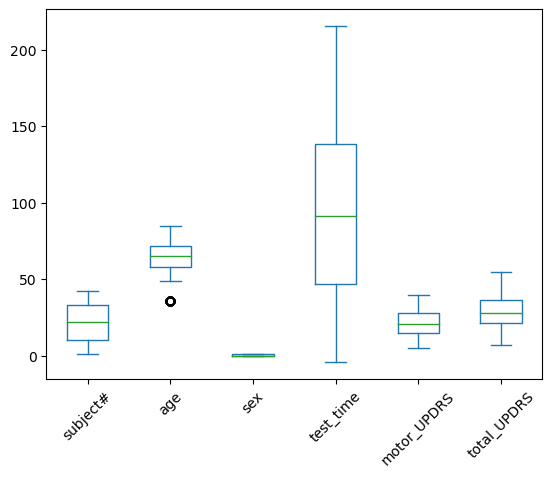

In [14]:
plt.figure(figsize=(10,10))

data[['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS']].plot(kind='box')
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x1000 with 0 Axes>

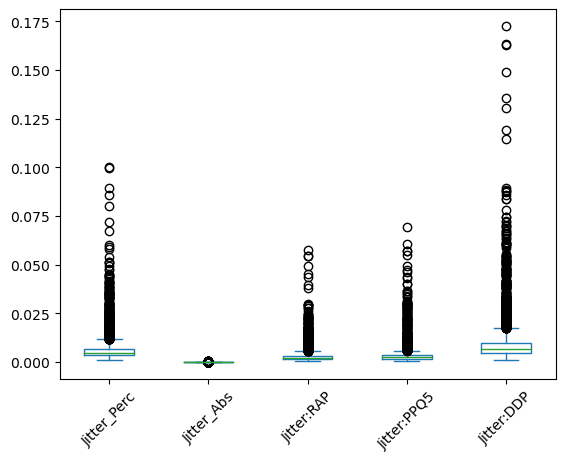

In [15]:
plt.figure(figsize=(10,10))

data[['Jitter_Perc', 'Jitter_Abs', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP']].plot(kind='box')
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x1000 with 0 Axes>

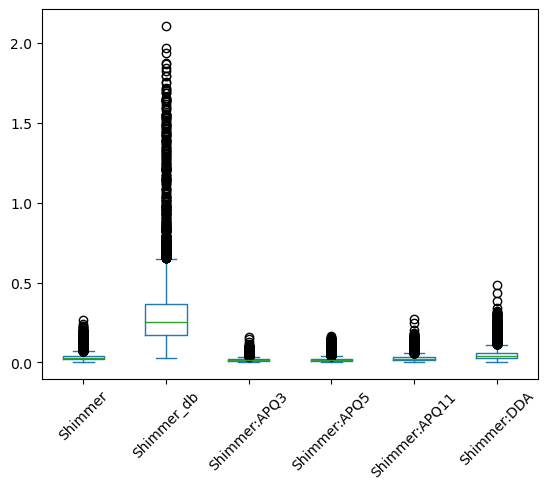

In [16]:
plt.figure(figsize=(10,10))

data[['Shimmer', 'Shimmer_db', 'Shimmer:APQ3', 'Shimmer:APQ5','Shimmer:APQ11', 'Shimmer:DDA']].plot(kind='box')
plt.xticks(rotation=45)
plt.show()

<Figure size 1000x1000 with 0 Axes>

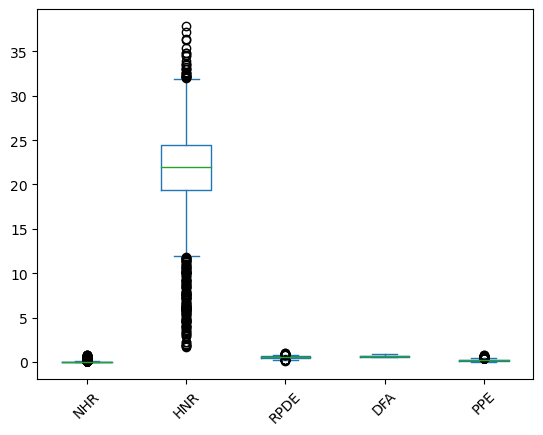

In [17]:
plt.figure(figsize=(10,10))

data[['NHR', 'HNR', 'RPDE', 'DFA', 'PPE']].plot(kind='box')
plt.xticks(rotation=45)
plt.show()

Аномалии присутсвуют в таких признаках, как: 'age', 'Jitter_Perc', 'Jitter_Abs', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 
'Shimmer', 'Shimmer_db', 'Shimmer:APQ3', 'Shimmer:APQ5','Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'PPE'
посмотрим отдельно по каждому признаку с аномалиями значения его квартилей и выведем строки с непосредственно выбросами.

In [18]:
# потсорим сводную таблцу, в которой показаны значения квартилей и количество выбросов по каждому признаку
q1 = []
q3 = []
iqr = []
count = []

col_names = data.columns[:]
for col in col_names:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    q1.append(Q1)
    q3.append(Q3)
    iqr.append(Q3 - Q1)
    count.append(len(data[(data[col] < Q1-1.5*IQR ) | (data[col] > Q3+1.5*IQR)]))
    

table_content = {'Q1': q1, 'IQR': iqr, 'Q3': q3, 'count': count}


table_anomaly_research = pd.DataFrame(table_content, index=col_names)
table_anomaly_research

Q1        IQR          Q3  count
subject#       10.000000  23.000000   33.000000      0
age            58.000000  14.000000   72.000000    101
sex             0.000000   1.000000    1.000000      0
test_time      46.847500  91.597500  138.445000      0
motor_UPDRS    15.000000  12.596500   27.596500      0
total_UPDRS    21.371000  15.028000   36.399000      0
Jitter_Perc     0.003580   0.003220    0.006800    398
Jitter_Abs      0.000022   0.000031    0.000053    366
Jitter:RAP      0.001580   0.001710    0.003290    414
Jitter:PPQ5     0.001820   0.001640    0.003460    425
Jitter:DDP      0.004730   0.005140    0.009870    413
Shimmer         0.019120   0.020630    0.039750    333
Shimmer_db      0.175000   0.190000    0.365000    332
Shimmer:APQ3    0.009280   0.011295    0.020575    332
Shimmer:APQ5    0.010790   0.012965    0.023755    314
Shimmer:APQ11   0.015665   0.017050    0.032715    314
Shimmer:DDA     0.027830   0.033905    0.061735    331
NHR             0.010955   0.020508    0.031463    436
HNR            19.406000   5.038000   24.444000    171
RPDE            0.469785   0.144260    0.614045     26
DFA             0.596180   0.115155    0.711335      0
PPE             0.156340   0.108150    0.264490    206

In [19]:
#Смотрим на выбросы по признаку age
Q1 =  data.age.quantile(0.25)
Q3 = data.age.quantile(0.75)
IQR = Q3 - Q1

print(Q1)
print(IQR)
print(Q3)

data[(data.age < Q1-1.5*IQR ) | (data.age > Q3+1.5*IQR)]['age'].value_counts()

58.0
14.0
72.0


36    101
Name: age, dtype: int64

In [20]:
data.shape

(5875, 22)

Согласно статистике дебют заболевания может приходиться на возраст 60-65 лет, с увеличением возраста увеличивается и заболеваемость, но в 5-10% пациентов болезнь появляется в возрасте до 40 лет. Количество пациентов с болезнью Паркинсона в данном датасете составляет 1.7% от общего количества. Такими данными нельзя пренебрегать, поэтому при обучнии модели машинного обучения, мы будем рассматривать данные аномалии. 

Показатели Jitter (%), Jitter (Abs), Jitter: RAP, Jitter: PPQ5 и Jitter: DDP представляют собой меры изменчивости фундаментальной частоты голоса. Эти показатели могут изменяться в зависимости от возраста, пола и состояния здоровья человека, а также от технических аспектов записи звука, таких как шумы и искажения.

Изменчивость фундаментальной частоты голоса может быть вызвана различными физиологическими и патологическими причинами, такими как изменения в работе дыхательной, голосовой и звукопроизводящей систем. У пациентов с болезнью Паркинсона может быть увеличена изменчивость фундаментальной частоты голоса из-за дисфункции боковых ядер головного мозга, которые контролируют голосовые функции.

Для более конкретной оценки значимости и природы этих признаков проведем корреляционный анализ между каждым признаком и целевыми переменными, а также построим гистограммы, чтобы оценить распределение значений признаков и наличие выбросов.

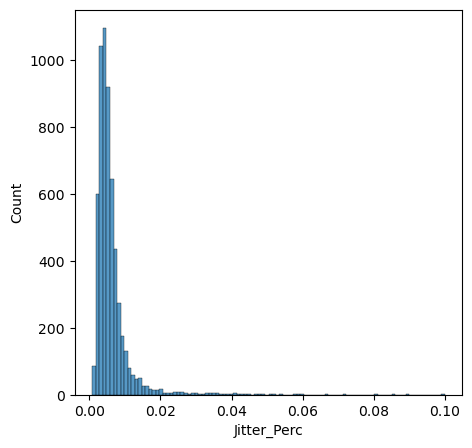

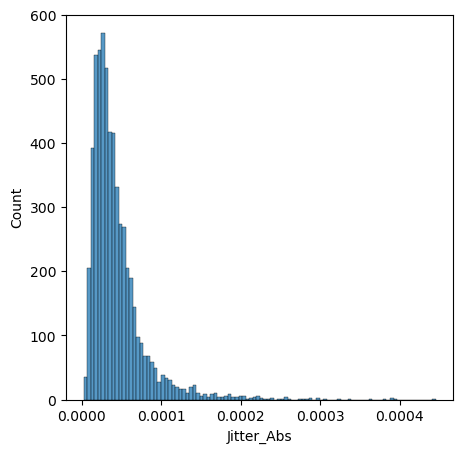

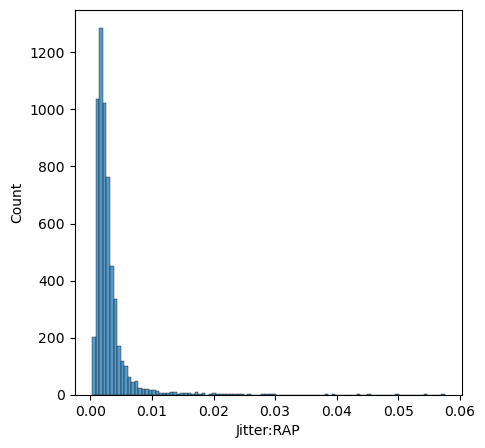

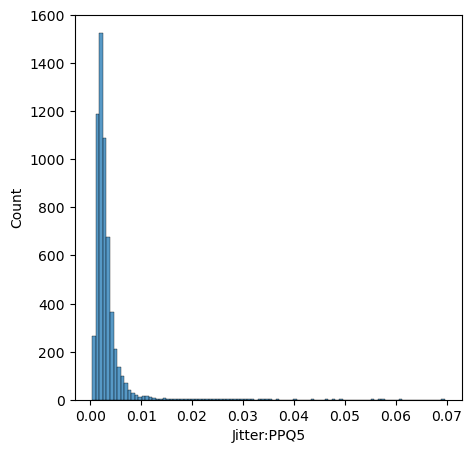

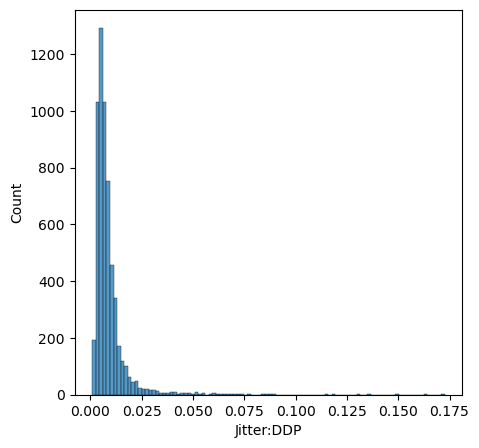

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

col_arr = ['Jitter_Perc', 'Jitter_Abs', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP']


for i in col_arr:
    plt.figure(figsize=(5,5))

    sns.histplot(data[i], bins=100)

Shimmer, Shimmer(dB), Shimmer:APQ3, Shimmer:APQ5, Shimmer:APQ11 и Shimmer:DDA являются показателями изменчивости амплитуды звука голоса. В целом, эти показатели могут быть связаны с моторными симптомами болезни Паркинсона, так как нарушения моторных функций могут сказываться на голосе человека. Однако, выбросы по этим признакам могут указывать на проблемы при сборе данных, например, на наличие шума в записях голоса.

Для более конкретной оценки значимости и природы этих признаков проведем корреляционный анализ между каждым признаком и целевыми переменными, а также построим гистограммы, чтобы оценить распределение значений признаков и наличие выбросов. 

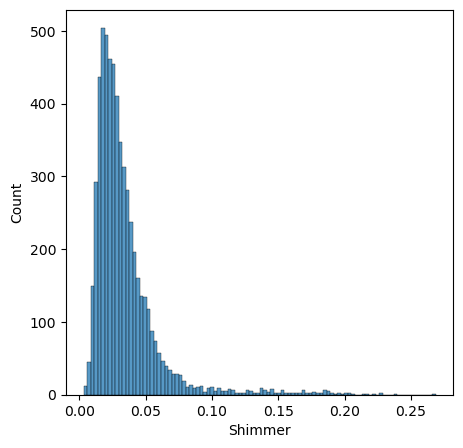

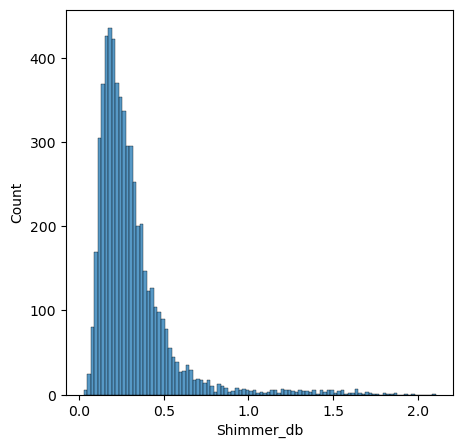

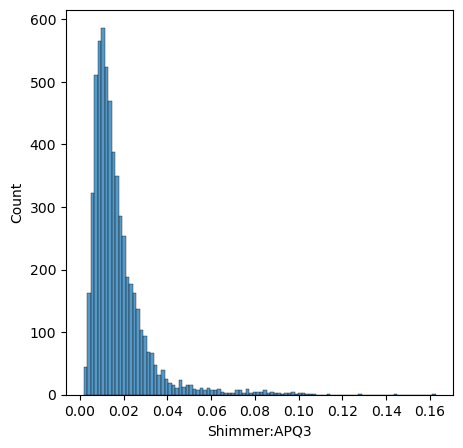

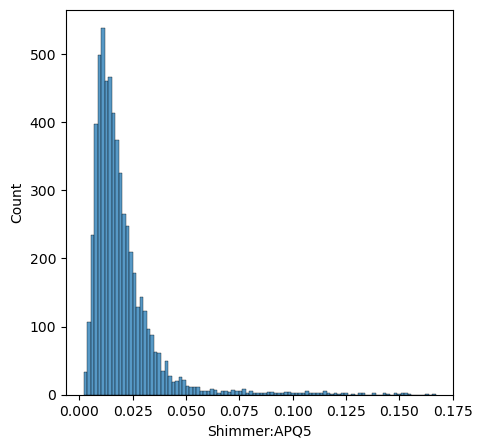

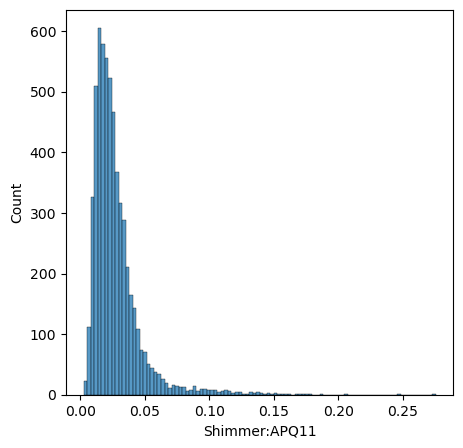

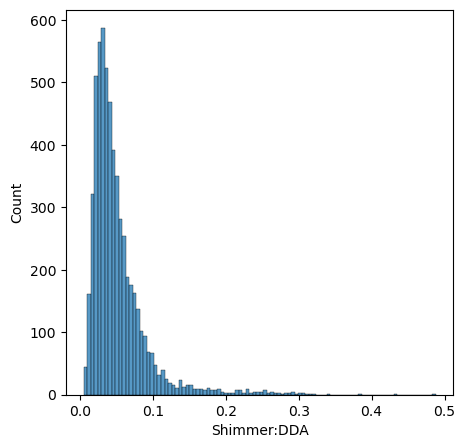

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

col_arr = ['Shimmer', 'Shimmer_db', 'Shimmer:APQ3', 'Shimmer:APQ5','Shimmer:APQ11', 'Shimmer:DDA']


for i in col_arr:
    plt.figure(figsize=(5,5))

    sns.histplot(data[i], bins=100)

Вышеизложенные признаки смещены влево и содержат выбросы, это может указывать на несколько возможных причин.

Во-первых, это может свидетельствовать о том, что большинство пациентов в этом датасете имеют легкую или умеренную форму заболевания, где изменения моторных функций не слишком выражены. В таком случае, можно ожидать, что большинство признаков будут иметь меньшие значения и будут смещены влево.

Во-вторых, смещение влево может быть связано с техническими проблемами при сборе данных, такими как неправильная калибровка оборудования или наличие шума в записях голоса. В этом случае, выбросы могут указывать на проблемы с качеством данных.


Для того, чтобы более точно определить причины смещения данных влево и наличия выбросов, проведем дополнительный анализ данных. В частности, можно проверим корреляцию между признаками и другими медицинскими показателями и построить графики попарных отношений относительно целевой переменной.

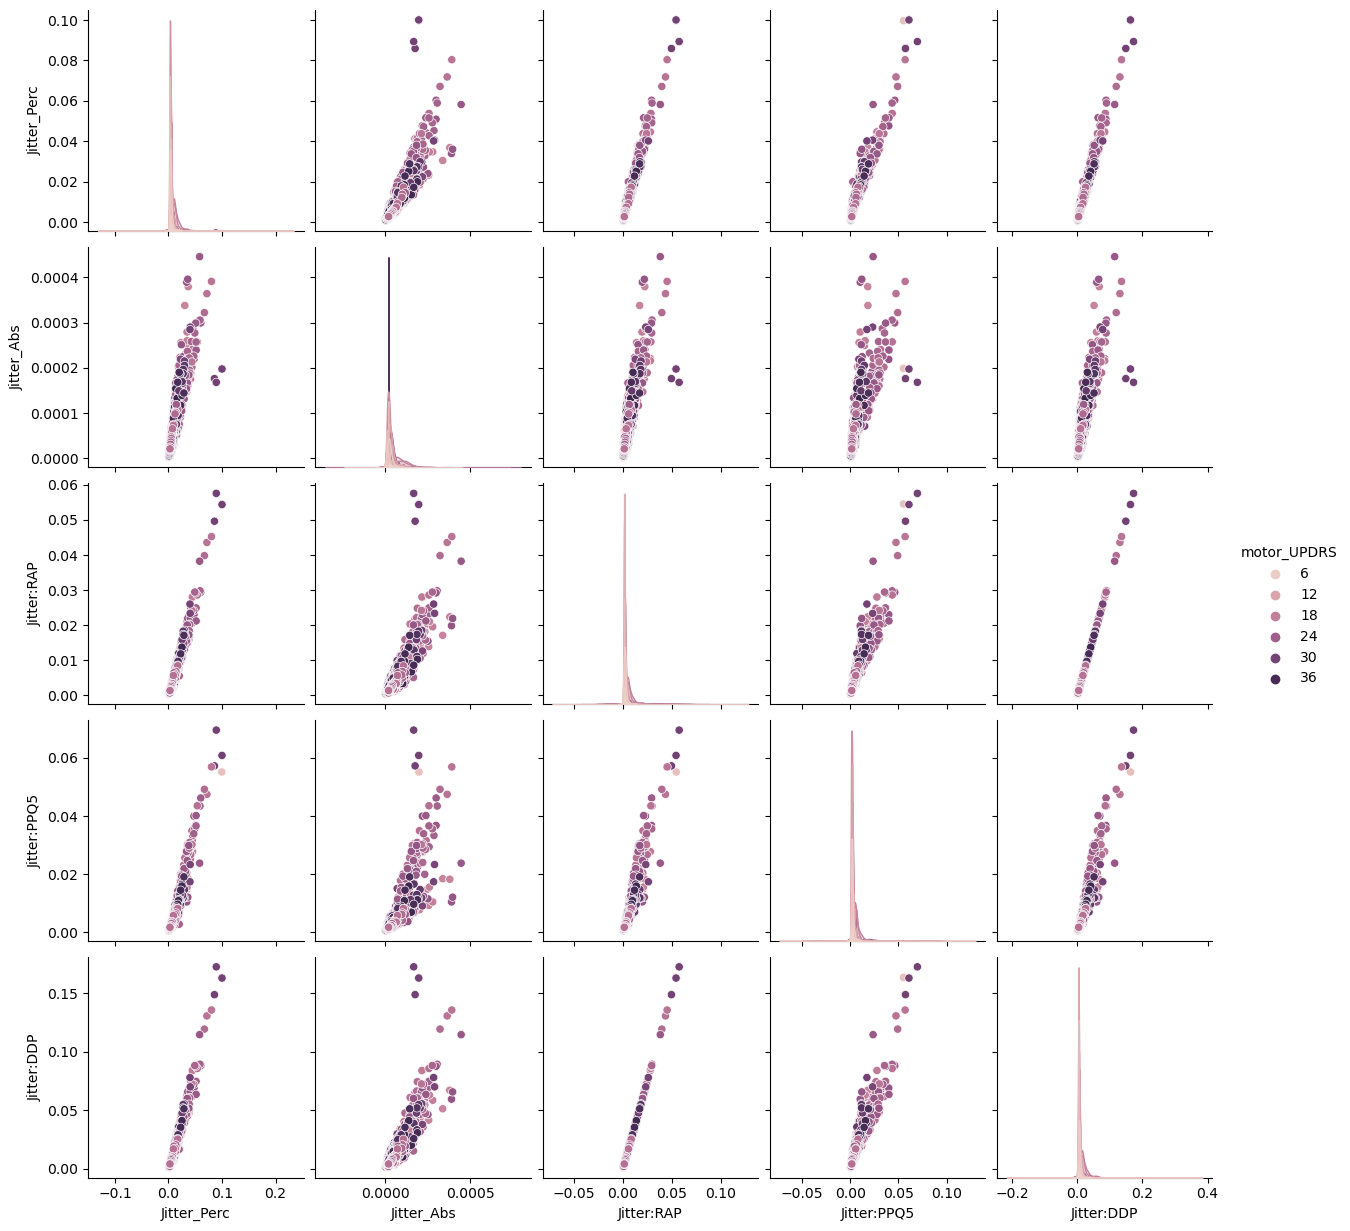

In [23]:
tmp = data[['Jitter_Perc', 'Jitter_Abs', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP', 'motor_UPDRS']]
sns.pairplot(tmp, hue = 'motor_UPDRS')

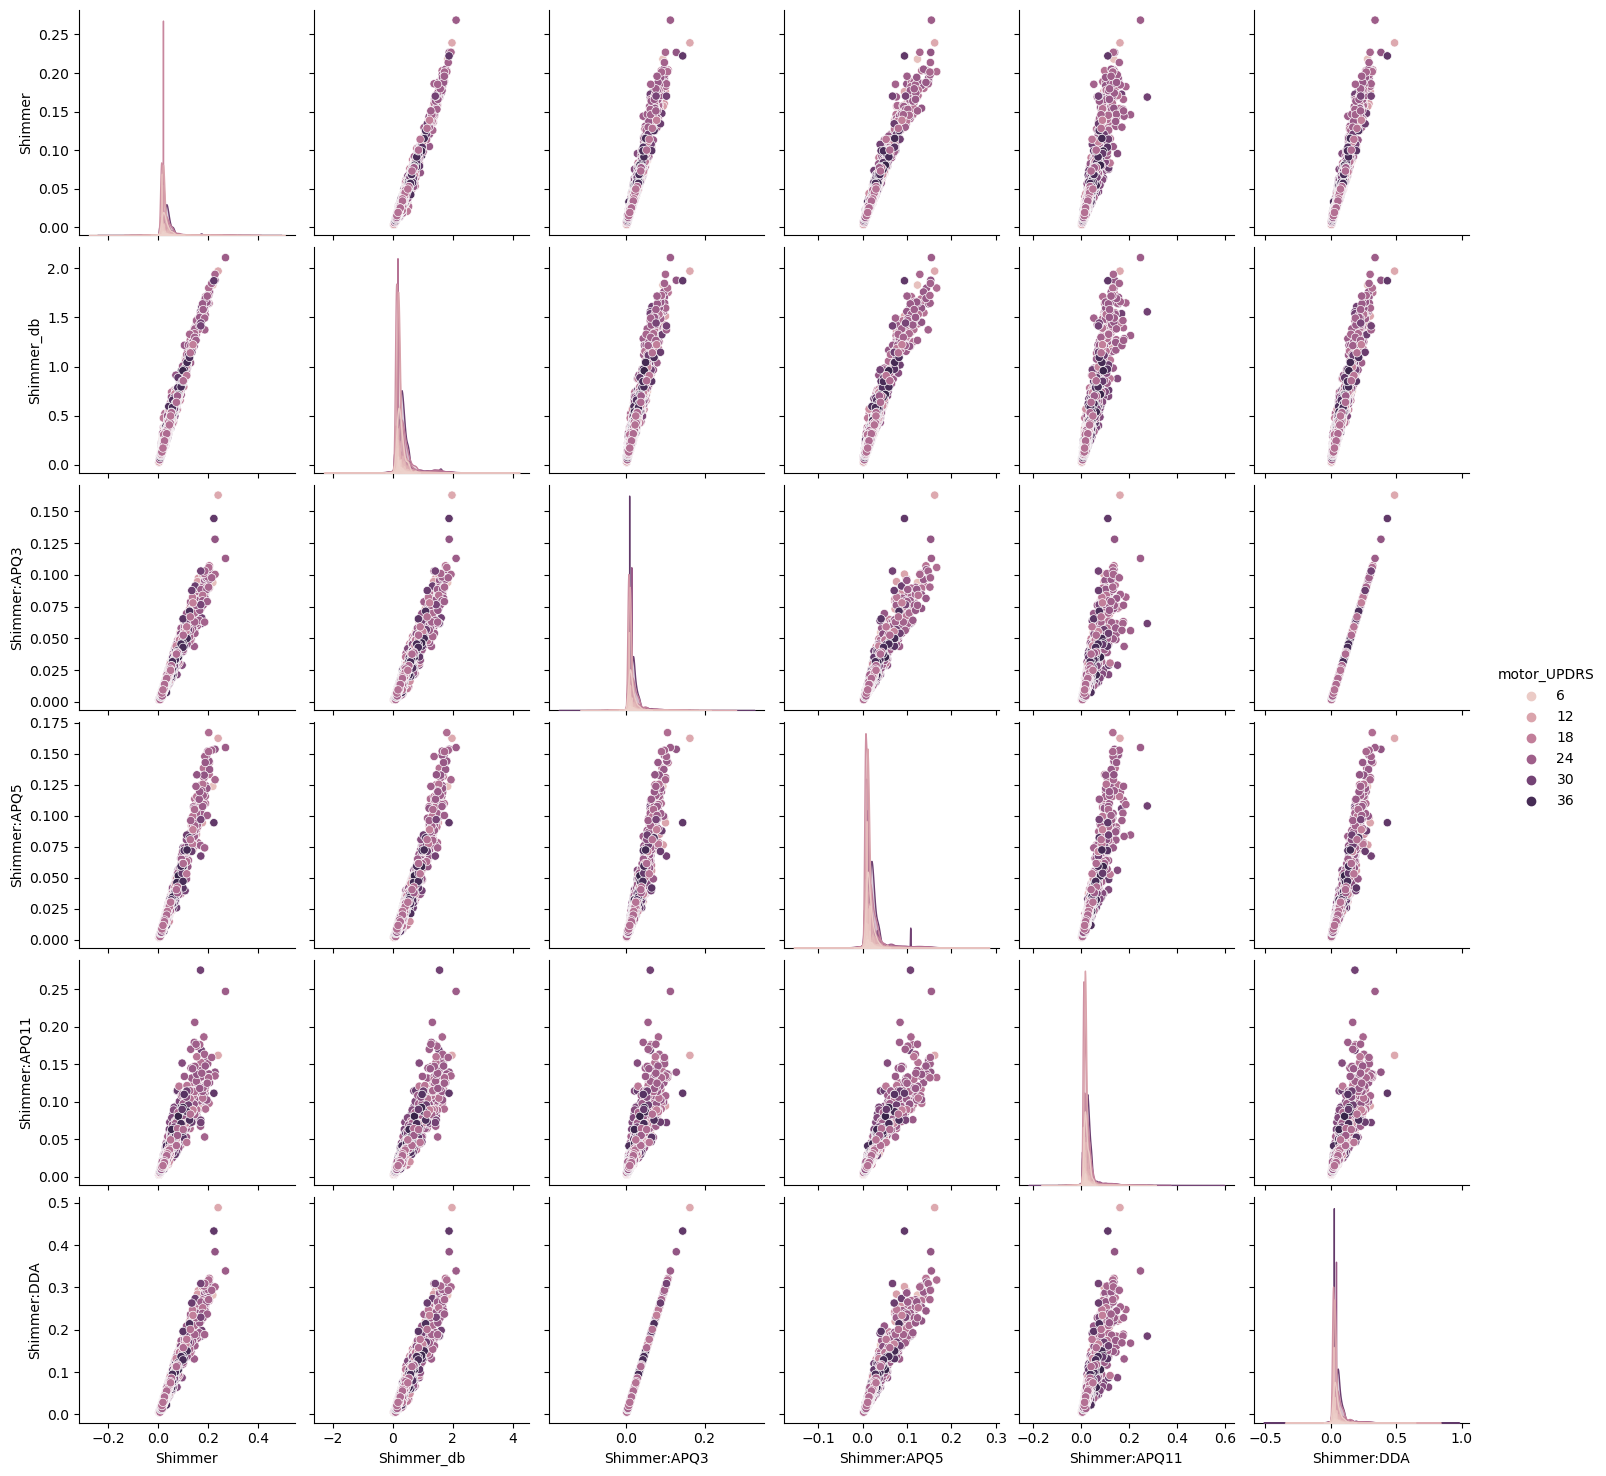

In [24]:
tmp = data[[ 'Shimmer', 'Shimmer_db', 'Shimmer:APQ3', 'Shimmer:APQ5','Shimmer:APQ11', 'Shimmer:DDA', 'motor_UPDRS']]
sns.pairplot(tmp, hue = 'motor_UPDRS')

In [25]:
df_corr = df.corr()

corr_features=[]
for i in range(len(df_corr.columns)):
    for j in range(i):
        if abs(df_corr.iloc[i,j])>0.8:
            colname=df_corr.columns[i]
            corr_features.append(colname)
set(corr_features)

{'HNR',
 'Jitter(Abs)',
 'Jitter:DDP',
 'Jitter:PPQ5',
 'Jitter:RAP',
 'NHR',
 'Shimmer(dB)',
 'Shimmer:APQ11',
 'Shimmer:APQ3',
 'Shimmer:APQ5',
 'Shimmer:DDA',
 'total_UPDRS'}

Исходя из графиков попарных соотношений + массив значений, чья корреляция по признаковому пространству составляет выше 0.7 можно сделать вывод, что технических проблем при сборе данных, таких как неправильная калибровка оборудования или наличие шума в записях голоса не было и данные собраны качественным оборудованием без зашумления. Данные выбросы свидетельствуют о физиологическом состоянии пациентов.
Такие выбросы нельзя удалить или заменить, они должны присутствовать при обучении модели ML

# 2.5. Масштабирование данных

Произведем масштабирование данных

In [26]:
data = scaling.data_scaling(data)

In [27]:
data

subject#       age       sex  test_time  motor_UPDRS  total_UPDRS  \
0    -1.656596  0.815695 -0.682509  -1.632090     0.849197     0.502745   
1    -1.656596  0.815695 -0.682509  -1.500676     0.879706     0.549103   
2    -1.656596  0.815695 -0.682509  -1.369410     0.910216     0.595367   
3    -1.656596  0.815695 -0.682509  -1.257773     0.936051     0.634716   
4    -1.656596  0.815695 -0.682509  -1.108169     0.970743     0.687522   
...        ...       ...       ...        ...          ...          ...   
5870  1.657546 -0.431361 -0.682509   0.934231     0.146246     0.417413   
5871  1.657546 -0.431361 -0.682509   1.066152     0.085104     0.370962   
5872  1.657546 -0.431361 -0.682509   1.196763     0.024453     0.324884   
5873  1.657546 -0.431361 -0.682509   1.326064    -0.035582     0.279274   
5874  1.657546 -0.431361 -0.682509   1.457050    -0.096355     0.233103   

      Jitter_Perc  Jitter_Abs  Jitter:RAP  Jitter:PPQ5  ...  Shimmer_db  \
0        0.082905   -0.284242    0.327453    -0.028637  ...   -0.351642   
1       -0.560793   -0.756723   -0.533746    -0.476212  ...   -0.573156   
2       -0.238944   -0.539382   -0.300038    -0.320767  ...   -0.564469   
3       -0.155370   -0.485186   -0.344859    -0.170682  ...    0.069668   
4       -0.498557   -0.663894   -0.658604    -0.529814  ...   -0.586186   
...           ...         ...         ...          ...  ...         ...   
5870    -0.372307   -0.358449   -0.421694    -0.427970  ...   -0.655681   
5871    -0.566128   -0.537436   -0.575365    -0.484252  ...   -0.416793   
5872    -0.473663   -0.537158   -0.469717    -0.377049  ...   -0.290834   
5873    -0.594579   -0.658336   -0.546552    -0.473532  ...   -0.781639   
5874    -0.592801   -0.637213   -0.524142    -0.433331  ...   -0.607903   

      Shimmer:APQ3  Shimmer:APQ5  Shimmer:APQ11  Shimmer:DDA       NHR  \
0        -0.209709     -0.423356      -0.543466    -0.209704 -0.298721   
1        -0.545158     -0.565592      -0.529955    -0.545153 -0.351965   
2        -0.741592     -0.702426      -0.645545    -0.741587 -0.199370   
3        -0.460540     -0.449763      -0.392849    -0.460787 -0.071754   
4        -0.783145     -0.651413      -0.464905    -0.783392 -0.343370   
...            ...           ...            ...          ...       ...   
5870     -0.561024     -0.528983      -0.600010    -0.560767 -0.116990   
5871     -0.501338     -0.442561      -0.422372    -0.501081 -0.338311   
5872     -0.260328     -0.335135      -0.435882    -0.260576 -0.241573   
5873     -0.772568     -0.686822      -0.721104    -0.772815 -0.404372   
5874     -0.581423     -0.516380      -0.639540    -0.581166 -0.401222   

           HNR      RPDE       DFA       PPE  
0    -0.009205 -1.214066 -1.478500 -0.650658  
1     1.282650 -1.055119 -1.247880 -1.218585  
2     0.318711 -0.784860 -1.540139 -0.103280  
3     0.644530 -0.536487 -1.062115  1.237075  
4     1.036305 -0.689195 -1.297953 -0.283954  
...        ...       ...       ...       ...  
5870  0.160696  0.997028 -1.411923 -0.064697  
5871  0.281189 -0.153430 -1.242097 -1.020641  
5872  0.789028 -0.629379 -1.048856 -0.852755  
5873  0.639170  0.269141 -1.269038 -0.847618  
5874  0.368120  0.441754 -1.163249 -0.723890  

[5875 rows x 22 columns]

# 3. Работаем с пропусками

data - после предобработки данных был получен эталонный датасет с которым будет происходить сравнение по метрикам

In [28]:
data.isna().sum()

subject#         0
age              0
sex              0
test_time        0
motor_UPDRS      0
total_UPDRS      0
Jitter_Perc      0
Jitter_Abs       0
Jitter:RAP       0
Jitter:PPQ5      0
Jitter:DDP       0
Shimmer          0
Shimmer_db       0
Shimmer:APQ3     0
Shimmer:APQ5     0
Shimmer:APQ11    0
Shimmer:DDA      0
NHR              0
HNR              0
RPDE             0
DFA              0
PPE              0
dtype: int64

In [29]:
data.shape

(5875, 22)

# 3.1. Искусственно создаем пропуски

In [30]:
# искусственно создаем пропуски в данных, которые впоследствии будем заполнять
# выбираем случайный признак
df_copy = data.copy()
np.random.seed(45)

random_feature = np.random.choice(df_copy.columns)

In [31]:
df1 = deletion_features.make_missing_value(df_copy, 0.05, random_feature)

<AxesSubplot:>

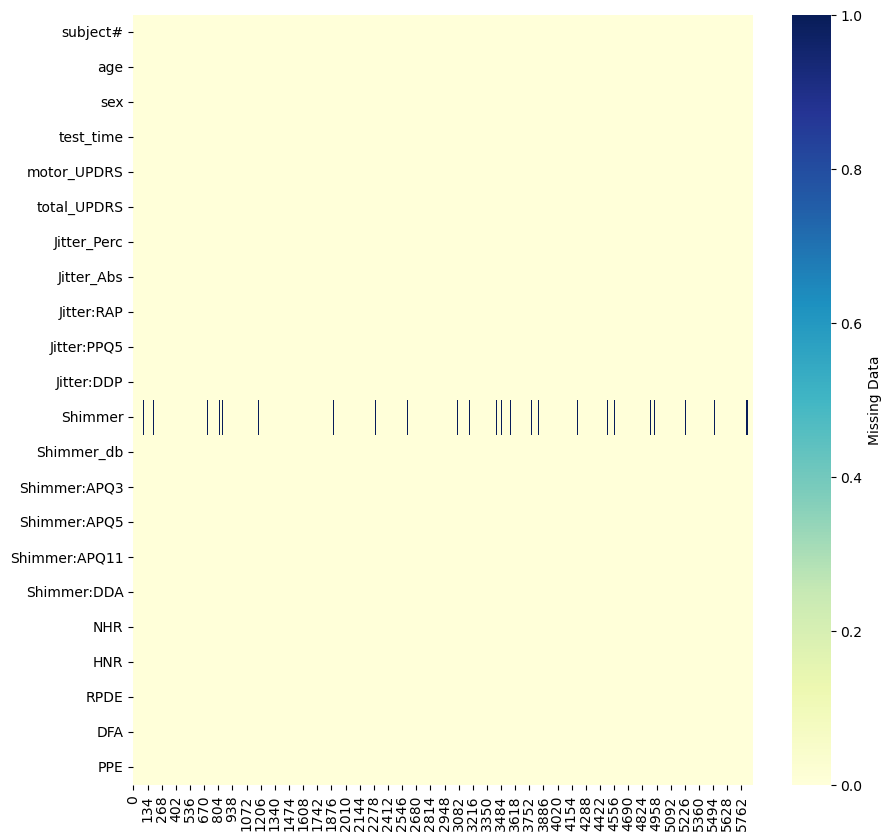

In [32]:
#визуализируем наличие пропусков
plt.figure(figsize=(10,10))
sns.heatmap(pd.DataFrame(df1).isna().transpose(), cmap = "YlGnBu", cbar_kws={'label':'Missing Data'})

In [33]:
df1.isna().sum()

subject#           0
age                0
sex                0
test_time          0
motor_UPDRS        0
total_UPDRS        0
Jitter_Perc        0
Jitter_Abs         0
Jitter:RAP         0
Jitter:PPQ5        0
Jitter:DDP         0
Shimmer          293
Shimmer_db         0
Shimmer:APQ3       0
Shimmer:APQ5       0
Shimmer:APQ11      0
Shimmer:DDA        0
NHR                0
HNR                0
RPDE               0
DFA                0
PPE                0
dtype: int64

создадим датасет с 15% пропусков для сравнения результатов заполнения

In [34]:
df15 = deletion_features.make_missing_value(df_copy, 0.2, random_feature)
df15.isna().sum()

subject#            0
age                 0
sex                 0
test_time           0
motor_UPDRS         0
total_UPDRS         0
Jitter_Perc         0
Jitter_Abs          0
Jitter:RAP          0
Jitter:PPQ5         0
Jitter:DDP          0
Shimmer          1175
Shimmer_db          0
Shimmer:APQ3        0
Shimmer:APQ5        0
Shimmer:APQ11       0
Shimmer:DDA         0
NHR                 0
HNR                 0
RPDE                0
DFA                 0
PPE                 0
dtype: int64

In [35]:
df20 = deletion_features.make_missing_value(df_copy, 0.35, random_feature)
df20.isna().sum()

subject#            0
age                 0
sex                 0
test_time           0
motor_UPDRS         0
total_UPDRS         0
Jitter_Perc         0
Jitter_Abs          0
Jitter:RAP          0
Jitter:PPQ5         0
Jitter:DDP          0
Shimmer          2056
Shimmer_db          0
Shimmer:APQ3        0
Shimmer:APQ5        0
Shimmer:APQ11       0
Shimmer:DDA         0
NHR                 0
HNR                 0
RPDE                0
DFA                 0
PPE                 0
dtype: int64

# 3.2. Заполняем пропуски

#1. Заполним пропуски средним арифметическим значением по признаку

In [36]:
df_mean_fill = mean_fill.mean_fill(df1)

#2. Заполним пропуски медианным значением по признаку

In [37]:
df_median_fill = median_fill.median_fill(df1)

#3. Заполним пропуски минимальным значением по признаку

In [38]:
df_min_fill = min_fill.min_fill(df1)

#4. Заполним пропуски максимальным значением по признаку

In [39]:
df_max_fill = df_min_fill = max_fill.max_fill(df1)

#5. Заполним пропуски используя интерполяцию

In [40]:
df_interpolate_fill = interpolate_fill.interpolate_fill(df1)

#6. Заполним пропуски используя линейную регрессию

In [41]:
df_LinearReg_fill = LinearRegression_fill.linreg_imputer(df1)

#7 Заполним пропуски используя KNNImputer

In [42]:
df_KNNImputer_fill = KNNImputer_fill.KNNImputer_fill(df1)

#8 Заполним пропуски используя дерево решений

In [43]:
df_DecisionTree_fill = DecisionTreeRegressor_fill.DecisionTree_imputer(df1)

#9 Заполним пропуски используя случайный лес

In [44]:
df_RandomForest_fill = RandomForestRegressor_fill.RandomForest_imputer(df1)

#10 Заполним пропуски используя SVM

In [45]:
df_SVM_fill = SVR_fill.SVM_imputer(df1)

#11 Заполним пропуски используя градиентный бустинг - XGboost

In [46]:
df_XGBRegressor_fill = XGBRegressor_fill.XGBRegressor_imputer(df1)

#12 Заполним пропуски используя градиентный бустинг - CatBoost

In [47]:
df_CatBoostRegressor_fill = CatBoostRegressor_fill.CatBoostRegressor_imputer(df1)

# 4. Формируем результаты эксперимента

In [48]:
all_methods = [df_mean_fill, df_median_fill, df_min_fill, df_max_fill, df_interpolate_fill, df_LinearReg_fill, df_KNNImputer_fill, df_DecisionTree_fill, df_RandomForest_fill, df_SVM_fill, df_XGBRegressor_fill, df_CatBoostRegressor_fill]
df1_result = results_metrics.generate_results_metrics(data, all_methods)
df1_result

Mean_absolute_error  Mean_squared_error  r2_score
Mean                          0.001464            0.002390  0.997478
Median                        0.001385            0.002573  0.997293
Min                           0.020508            0.187913  0.961309
Max                           0.020508            0.187913  0.961309
Interpolate                   0.001083            0.001500  0.998476
LinearReg                     0.000089            0.000012  0.999988
KNNImputer                    0.000254            0.000066  0.999934
DecisionTree                  0.000131            0.000023  0.999977
RandomForest                  0.000083            0.000011  0.999989
SVM                           0.000163            0.000078  0.999922
XGBRegressor                  0.000093            0.000015  0.999985
CatBoostRegressor             0.000094            0.000016  0.999984

In [49]:
all_methods = [mean_fill.mean_fill(df15), median_fill.median_fill(df15), min_fill.min_fill(df15), max_fill.max_fill(df15), interpolate_fill.interpolate_fill(df15),
              LinearRegression_fill.linreg_imputer(df15), KNNImputer_fill.KNNImputer_fill(df15), DecisionTreeRegressor_fill.DecisionTree_imputer(df15),
              RandomForestRegressor_fill.RandomForest_imputer(df15), SVR_fill.SVM_imputer(df15), XGBRegressor_fill.XGBRegressor_imputer(df15), CatBoostRegressor_fill.CatBoostRegressor_imputer(df15)]
df15_result = results_metrics.generate_results_metrics(data, all_methods)
df15_result

Mean_absolute_error  Mean_squared_error  r2_score
Mean                          0.006000            0.010578  0.986214
Median                        0.005617            0.011226  0.985546
Min                           0.011087            0.024093  0.975795
Max                           0.082371            0.756912  0.945846
Interpolate                   0.004345            0.006082  0.993536
LinearReg                     0.000385            0.000069  0.999931
KNNImputer                    0.001093            0.000319  0.999673
DecisionTree                  0.000520            0.000103  0.999897
RandomForest                  0.000361            0.000055  0.999945
SVM                           0.000698            0.000527  0.999452
XGBRegressor                  0.000393            0.000060  0.999940
CatBoostRegressor             0.000366            0.000062  0.999938

In [50]:
all_methods = [mean_fill.mean_fill(df20), median_fill.median_fill(df20), min_fill.min_fill(df20), max_fill.max_fill(df20), interpolate_fill.interpolate_fill(df20), 
              LinearRegression_fill.linreg_imputer(df20), KNNImputer_fill.KNNImputer_fill(df20), DecisionTreeRegressor_fill.DecisionTree_imputer(df20),
              RandomForestRegressor_fill.RandomForest_imputer(df20), SVR_fill.SVM_imputer(df20), XGBRegressor_fill.XGBRegressor_imputer(df20), CatBoostRegressor_fill.CatBoostRegressor_imputer(df20)]
df20_result = results_metrics.generate_results_metrics(data, all_methods)
df20_result

Mean_absolute_error  Mean_squared_error  r2_score
Mean                          0.009888            0.016042  0.975209
Median                        0.009294            0.017168  0.974041
Min                           0.019240            0.039310  0.959520
Max                           0.144290            1.324854  0.931817
Interpolate                   0.007734            0.010161  0.989231
LinearReg                     0.000628            0.000077  0.999923
KNNImputer                    0.001946            0.000557  0.999421
DecisionTree                  0.000922            0.000179  0.999821
RandomForest                  0.000632            0.000093  0.999907
SVM                           0.001090            0.000789  0.999163
XGBRegressor                  0.000654            0.000097  0.999903
CatBoostRegressor             0.000621            0.000098  0.999901

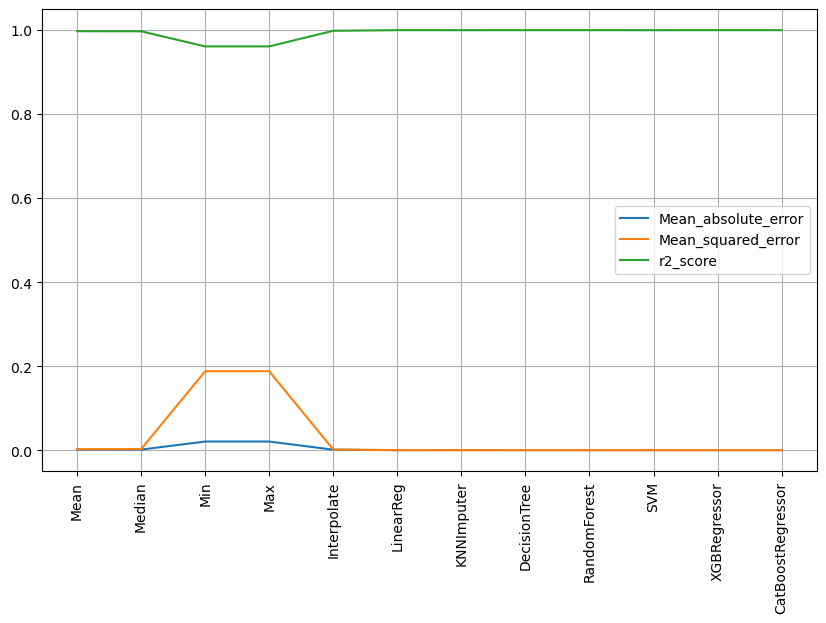

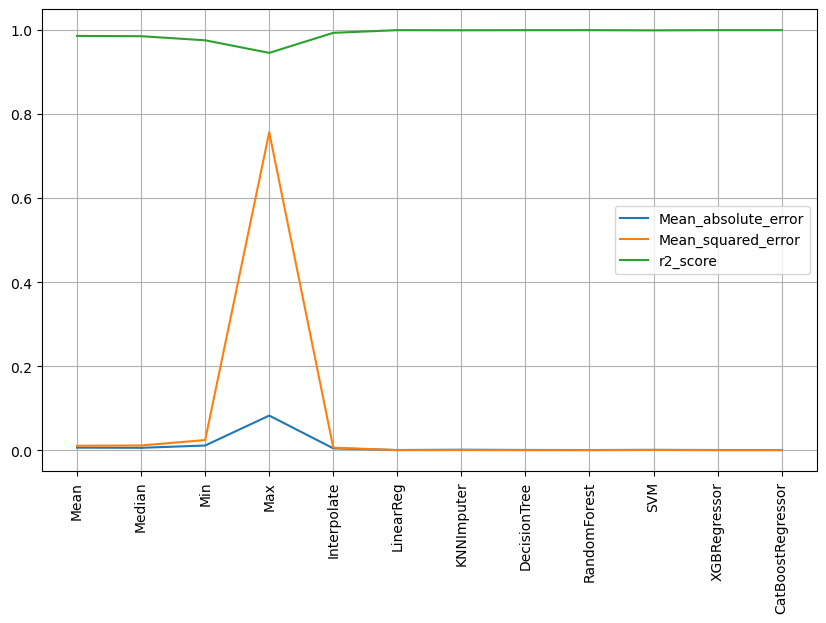

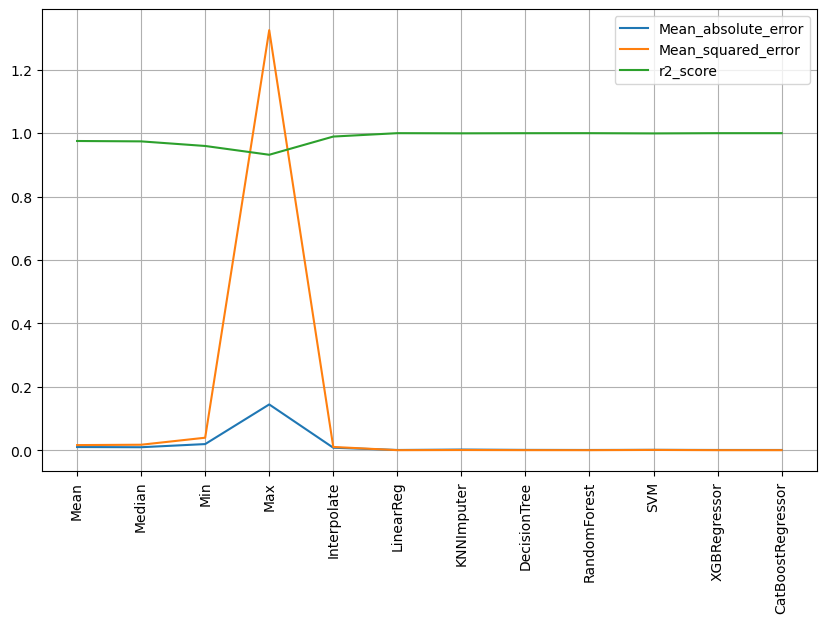

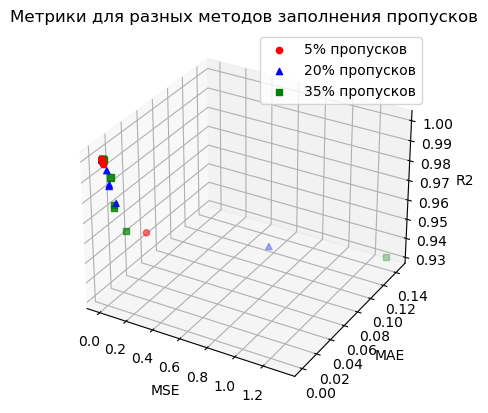

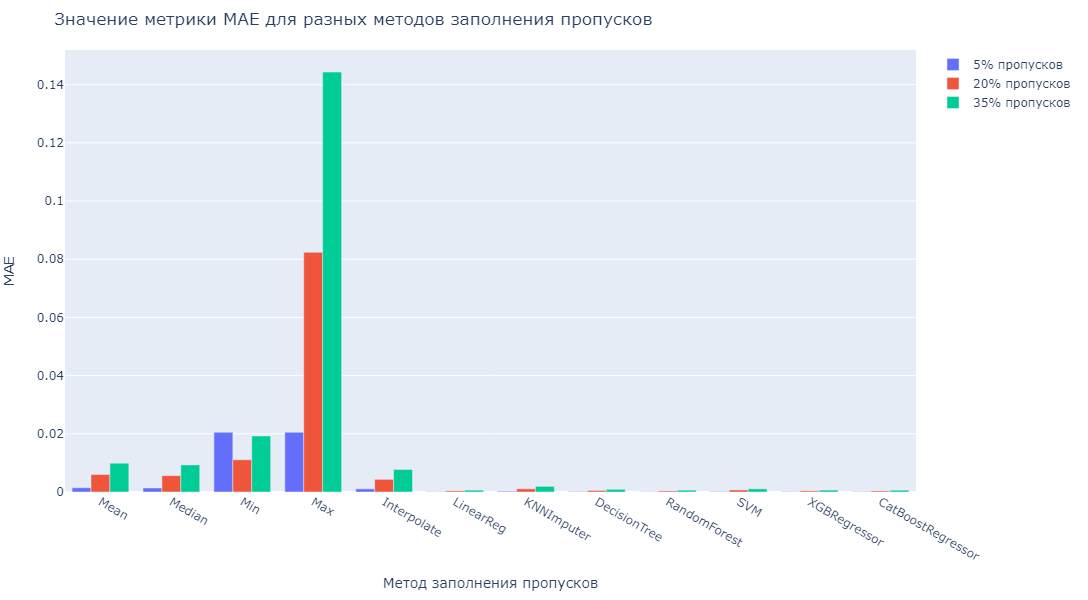

C:\Users\Ivan\Documents\university\ЮФУ_1_курс\Научные работы\Работа 6. Заполнение пропусков\Filling-in-Missing-Values\research\evaluate\results_metrics_visualization.py:147: UserWarning:

FixedFormatter should only be used together with FixedLocator

C:\Users\Ivan\Documents\university\ЮФУ_1_курс\Научные работы\Работа 6. Заполнение пропусков\Filling-in-Missing-Values\research\evaluate\results_metrics_visualization.py:148: UserWarning:

FixedFormatter should only be used together with FixedLocator



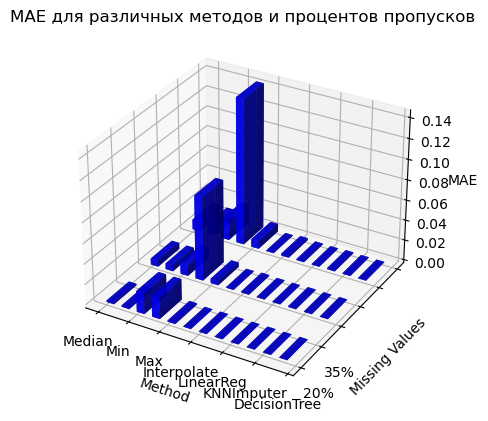

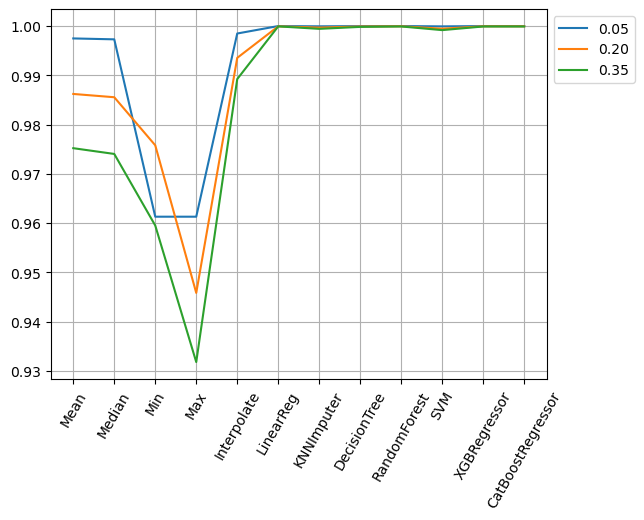

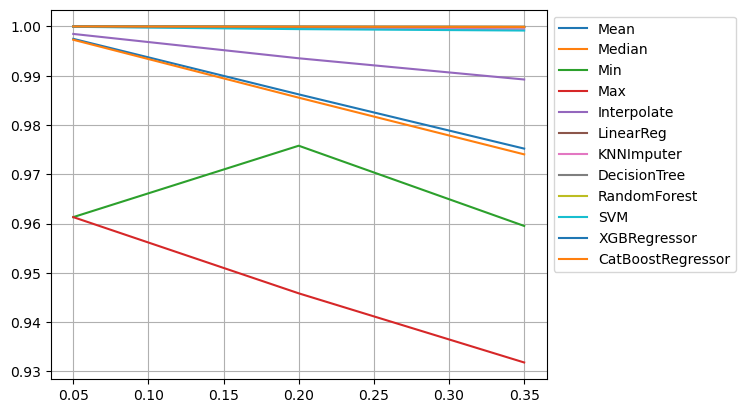

In [51]:
results_metrics_visualization.visualization_results_metrics(df1_result, df15_result, df20_result)